In [1]:
import copy
import easydict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim

from skimage.exposure import exposure
from skimage.feature import hog

import numpy as np
import matplotlib.pyplot as plt


# PreParing Data

In [2]:
# Data transforms
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.255]

data_transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
# Loading Datasets
datasets = {
    'train': torchvision.datasets.CIFAR10(root='./data', train=True, transform=data_transform['train'],
                                          download=True),
    'val': torchvision.datasets.CIFAR10(root='./data', train=False, transform=data_transform['val'],
                                        download=True)
}
print(type(datasets['train']))
print('*'*50)
# train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=data_transform['train'],
#                                              download=True)
# test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=data_transform['val'], download=True)

# Defining class names
class_names = datasets['train'].classes
print(f'Class names are {class_names}')

# Creating DataLoaders
batch_size = 32
dataloaders = {x: torch.utils.data.DataLoader(dataset=datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in
               ['train', 'val']}

print(len(dataloaders['train']))
print(dataloaders['train'])
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=2)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, num_workers=2)
print('DataLoaders Are Ready.')

Files already downloaded and verified
Files already downloaded and verified
<class 'torchvision.datasets.cifar.CIFAR10'>
**************************************************
Class names are ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
1563
DataLoaders Are Ready.


In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

# HOG Feature Extraction

In [17]:
# HOG Parameters
orientations = 8
pixels_per_cell = (8, 8)
cells_per_block = (1, 1)
block_norm = 'L2-Hys'


class HOGFeatureExtractor(nn.Module):
    def __init__(self):
        super(HOGFeatureExtractor, self).__init__()

    def forward(self, image):
        hog_features_list = torch.empty(3, 224, 224)
        image = image.cpu().numpy().squeeze()

        # Extract HOG features from each channel 
        for idx, channel in enumerate(image):
            _, hog_channel = hog(
                channel,
                orientations=orientations,
                pixels_per_cell=pixels_per_cell,
                cells_per_block=cells_per_block,
                block_norm=block_norm,
                visualize=True,
            )
            hog_channel = exposure.rescale_intensity(hog_channel, in_range=(0, 10))
            image[idx, :, :] = torch.Tensor(hog_channel)
                            
        image = torch.FloatTensor(image)
        hog_features_list.add_(image)
                
        hog_features_list = torch.Tensor(hog_features_list)        
        
        return hog_features_list.to(device)


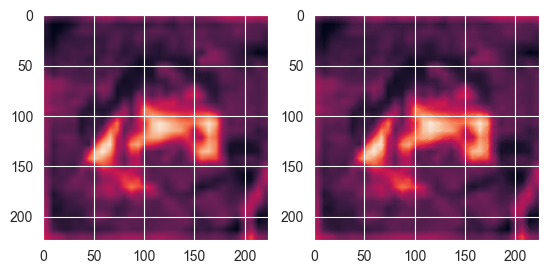

In [45]:
import PIL.Image as Image
import cv2 as cv


image, label = datasets['train'][0]

image = image.cpu()
plt.subplot(1,2,1)
plt.imshow(image[2])
 

ho = HOGFeatureExtractor()
image2 = ho(image)
image2 = image2.cpu()
plt.subplot(1,2,2)
plt.imshow(image2[2])
plt.show()

In [4]:
# HOG Parameters
orientations = 8
pixels_per_cell = (8, 8)
cells_per_block = (1, 1)
block_norm = 'L2-Hys'


class HOGFeatureExtractor(nn.Module):
    def __init__(self):
        super(HOGFeatureExtractor, self).__init__()

    def forward(self, x):
        hog_features_list = torch.empty(batch_size, 3, 224, 224)

        # Iterating over data in each batch and extract hog features 
        for image in x:
            # Convert Image to cpu tensor and numpy for hog
            image = image.cpu().numpy().squeeze()

            # Extract HOG features from each channel 
            img_channels = []
            for idx, channel in enumerate(image):
                _, hog_channel = hog(
                    channel,
                    orientations=orientations,
                    pixels_per_cell=pixels_per_cell,
                    cells_per_block=cells_per_block,
                    block_norm=block_norm,
                    visualize=True,
                )
                hog_channel = exposure.rescale_intensity(hog_channel, in_range=(0, 10))
                image[idx, :, :] = torch.Tensor(hog_channel)
                                
            image = torch.FloatTensor(image)
            hog_features_list.add_(image)
                
        hog_features_list = torch.Tensor(hog_features_list)        
        
        return hog_features_list.to(device)


In [5]:
# hog_extractor = HOGFeatureExtractor()
# for phase in ['train', 'val']:
#     for idx, data in enumerate(datasets[phase]):
#         image, label = data
#         print('hi', len(image))
#         hog_features = hog_extractor([image])
#         print(len(hog_features))
#         print(type(hog_features))
#         

# Setup pretrained model

In [8]:
# Load pretrained model
pretrained_model = models.resnet18(pretrained=True)

# Freeze all trainable layers
for param in pretrained_model.parameters():
    param.requires_grad = False

# Modifying last classification layer for our dataset
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_features, 10)

C:\Users\Mahdiar\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Mahdiar\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Defining loss function and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.fc.parameters(), lr=0.001)

# Train Function 

In [10]:
hog_features_extractor = HOGFeatureExtractor()

acc_list = easydict.EasyDict({'train': [], 'val': []})
loss_list = easydict.EasyDict({'train': [], 'val': []})


def train_model(model, criterion, optimizer, epoch_num=25):
    # Copy the best model weights for loading at the End
    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    # Iterating over epochs
    for epoch in range(1, epoch_num + 1):
        print(f'Epoch {epoch}/{epoch_num}:')

        # Each epoch has two phase Train and Validation
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # For calculating Loss and Accuracy at the end of epoch
            running_loss = 0.0
            running_corrects = 0.0

            # Iterating over batches and data for training and validation
            for idx, batch in enumerate(dataloaders[phase], 0):
                print(f'Batch {idx + 1}/{len(dataloaders[phase])} processing...')
                inputs, labels = batch

                # Transfer data and labels to CUDA if is available
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                # Extract HOG features
                input_hog_features = hog_features_extractor(inputs)
                
                print('data processing done...')

                # Forward Pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(input_hog_features)
                    loss = criterion(outputs, labels)
                    
                    _, predictions = torch.max(outputs, 1)
                    
                    # Back Propagation and updating weights
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * input_hog_features.size(0)
                running_corrects += torch.sum(predictions == labels.data)
            
            # Calculating Accuracy and Loss per phase
            epoch_loss = running_loss / len(datasets[phase])
            epoch_accuracy = running_corrects.double() / len(datasets[phase])
            
            # Show epoch details
            print(f'{phase.capitalize()} Accuracy: {epoch_accuracy:.4f} / Loss: {epoch_loss:.4f}')
            
            # Copy the model weights if its better
            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())  
                print('Best model weights updated!')
                
            # Save Loss and accuracy
            acc_list[phase].append(epoch_accuracy)
            loss_list[phase].append(epoch_loss)
        print()
        
    print(f'Best Accuracy: {best_accuracy:.4f}')
    
    # Loading best model weights 
    model.load_state_dict(best_model_wts)
    return model

In [11]:
model = pretrained_model.to(device)

# Train model
model = train_model(model, criterion, optimizer, 100)

Epoch 1/100:
Batch 1/1563 processing...
data processing done...
Batch 2/1563 processing...
data processing done...
Batch 3/1563 processing...
data processing done...
Batch 4/1563 processing...
data processing done...
Batch 5/1563 processing...
data processing done...
Batch 6/1563 processing...
data processing done...
Batch 7/1563 processing...
data processing done...
Batch 8/1563 processing...
data processing done...
Batch 9/1563 processing...
data processing done...
Batch 10/1563 processing...
data processing done...
Batch 11/1563 processing...
data processing done...
Batch 12/1563 processing...
data processing done...
Batch 13/1563 processing...
data processing done...
Batch 14/1563 processing...
data processing done...
Batch 15/1563 processing...


KeyboardInterrupt: 